In [1]:
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.4)

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

import pysindy as ps
from pysindy.feature_library import PolynomialLibrary
from pysindy.feature_library import WeakPDELibrary

from tqdm import tqdm

# Ignore matplotlib deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

# Ensemble SINDy

## Lorenz system

$$\dot{x} = -10x + 10y$$
$$\dot{y} = x(28-z) - y$$
$$\dot{z} = xy - \frac{8}{3} z$$

In [3]:
# Generate measurement data
def generate_lorenz_data(noise_f, dt=0.002, t_series=False):
    t_train = np.arange(0, 10, dt)
    t_train_span = (t_train[0], t_train[-1])
    x0_train = [-8, 8, 27]
    x_train = solve_ivp(
        lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
    ).y.T
    
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape))
    x_train = x_train + \
        np.random.normal(0, np.sqrt(rmse) * noise_f, x_train.shape)

    if t_series:
        return x_train, dt, t_train
    else:
        return x_train, dt

# Plot data
def plot_data(x_train):
    for i in range(x_train.shape[1]):
        plt.plot(x_train[:, i])
    plt.show()
    return

# Fit ensemble model
def fit_ensemble_sindy(x_train, dt, n_models=1000, max_degree=2):
    feature_names = ['x', 'y', 'z'][:len(x_train[0])]
    ensemble_optimizer = ps.STLSQ()
    poly_library = PolynomialLibrary(degree=max_degree, include_bias=True)
    model = ps.SINDy(
        feature_names=feature_names,
        feature_library=poly_library,
        optimizer=ensemble_optimizer,
    )
    model.fit(x_train, t=dt, ensemble=True, n_models=n_models, quiet=True)
    ensemble_coefs = np.asarray(model.coef_list)
    return model, ensemble_coefs

# Make plots of each coefficient distribution!
def plot_lorenz_coef_dist(ensemble_coefs):
    feature_names = ['x', 'y', 'z']

    n_sample, n_var, n_term = ensemble_coefs.shape
    plt.figure(figsize=(20, 2*n_term))

    if n_var == 3: # Lorenz
        true_coefs_d = {
            ('x', 'x') : -10,
            ('x', 'y') : 10,
            ('y', 'x') : 28,
            ('y', 'y') : -1,
            ('y', 'xz') : -1,
            ('z', 'z') : -8/3,
            ('z', 'xy') : 1,
        }
        min_overall = -12
        max_overall = 30
    elif n_var == 2: # Lotka-Volterra
        true_coefs_d = {
            ('x', 'x') : .1,
            ('x', 'xy') : -.02,
            ('y', 'y') : -.4,
            ('y', 'xy') : .02,
        }
        min_overall = -.5
        max_overall = .2
    elif n_var == 1: # Logistic
        true_coefs_d = {
            ('x', 'x') : 1,
            ('x', 'x^2') : -1,            
        }
        min_overall = -2
        max_overall = 2
    else:
        true_coefs_d = None

    xticknames = model.get_feature_names()
    
    # Loop through each element in the coefficients
    for j in range(n_term):
        for i in range(n_var):
            plt.subplot(n_term, n_var, i + 1 + j * n_var)
            if j == 0:
                plt.title(feature_names[i], fontsize=30)
            bins = np.linspace(min_overall, max_overall, 40)
            plt.hist(ensemble_coefs[:, i, j], color='b', bins=bins,
                     label='ensemble', align='left')
            if true_coefs_d is not None:
                try:
                    true_val = true_coefs_d[(feature_names[i], xticknames[j].replace(' ', ''))]
                except:
                    true_val = 0
                plt.scatter(true_val, 110.0, color='r',
                            label='true value', s=100, marker='o')
            plt.grid(True)
            ax = plt.gca()
            if i == 0:
                plt.ylabel(f'${xticknames[j]}$', fontsize=30)
            else:
                ax.set_yticklabels([])
            if j != (n_term-1):
                ax.set_xticklabels([])
            else:
                plt.xlabel('coefficient value', fontsize=30)
            #ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
            plt.ylim(0, 1000)
            plt.xlim(min_overall, max_overall)
            plt.xticks(fontsize=22)
            plt.yticks(fontsize=18)
            if i == (n_var-1) and j == (n_term-1):
                plt.legend(fontsize=16)
    plt.show()
    return

def get_nonzero_terms(model):
    nonzero_indices = np.nonzero(model.coefficients())[1]  # Get indices of non-zero terms
    term_names = model.get_feature_names()  # Get feature names
    nonzero_terms = [term_names[i] for i in nonzero_indices]
    return nonzero_terms

#### Very low noise

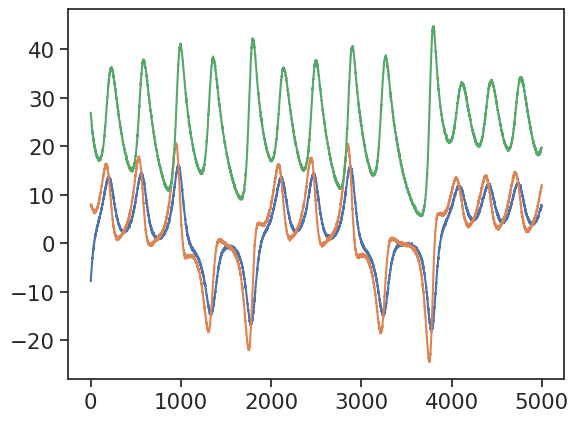

In [4]:
x_train, dt = generate_lorenz_data(0.01)
plot_data(x_train)

(x)' = -9.940 x + 9.946 y
(y)' = 27.771 x + -0.924 y + -0.995 x z
(z)' = 0.122 1 + -2.670 z + 0.999 x y
[[ 0.         -9.94033565  9.94637377  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         27.77070149 -0.923737    0.          0.          0.
  -0.99477042  0.          0.          0.        ]
 [ 0.12189182  0.          0.         -2.6702086   0.          0.99914331
   0.          0.          0.          0.        ]]
[[ 0.         -9.95674601  9.96210576  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         27.71948269 -0.90903564  0.          0.          0.
  -0.99424556  0.          0.          0.        ]
 [ 0.20518095  0.          0.         -2.67245379  0.          0.99959337
   0.          0.          0.          0.        ]]
['x', 'y', 'x', 'y', 'x z', '1', 'z', 'x y']


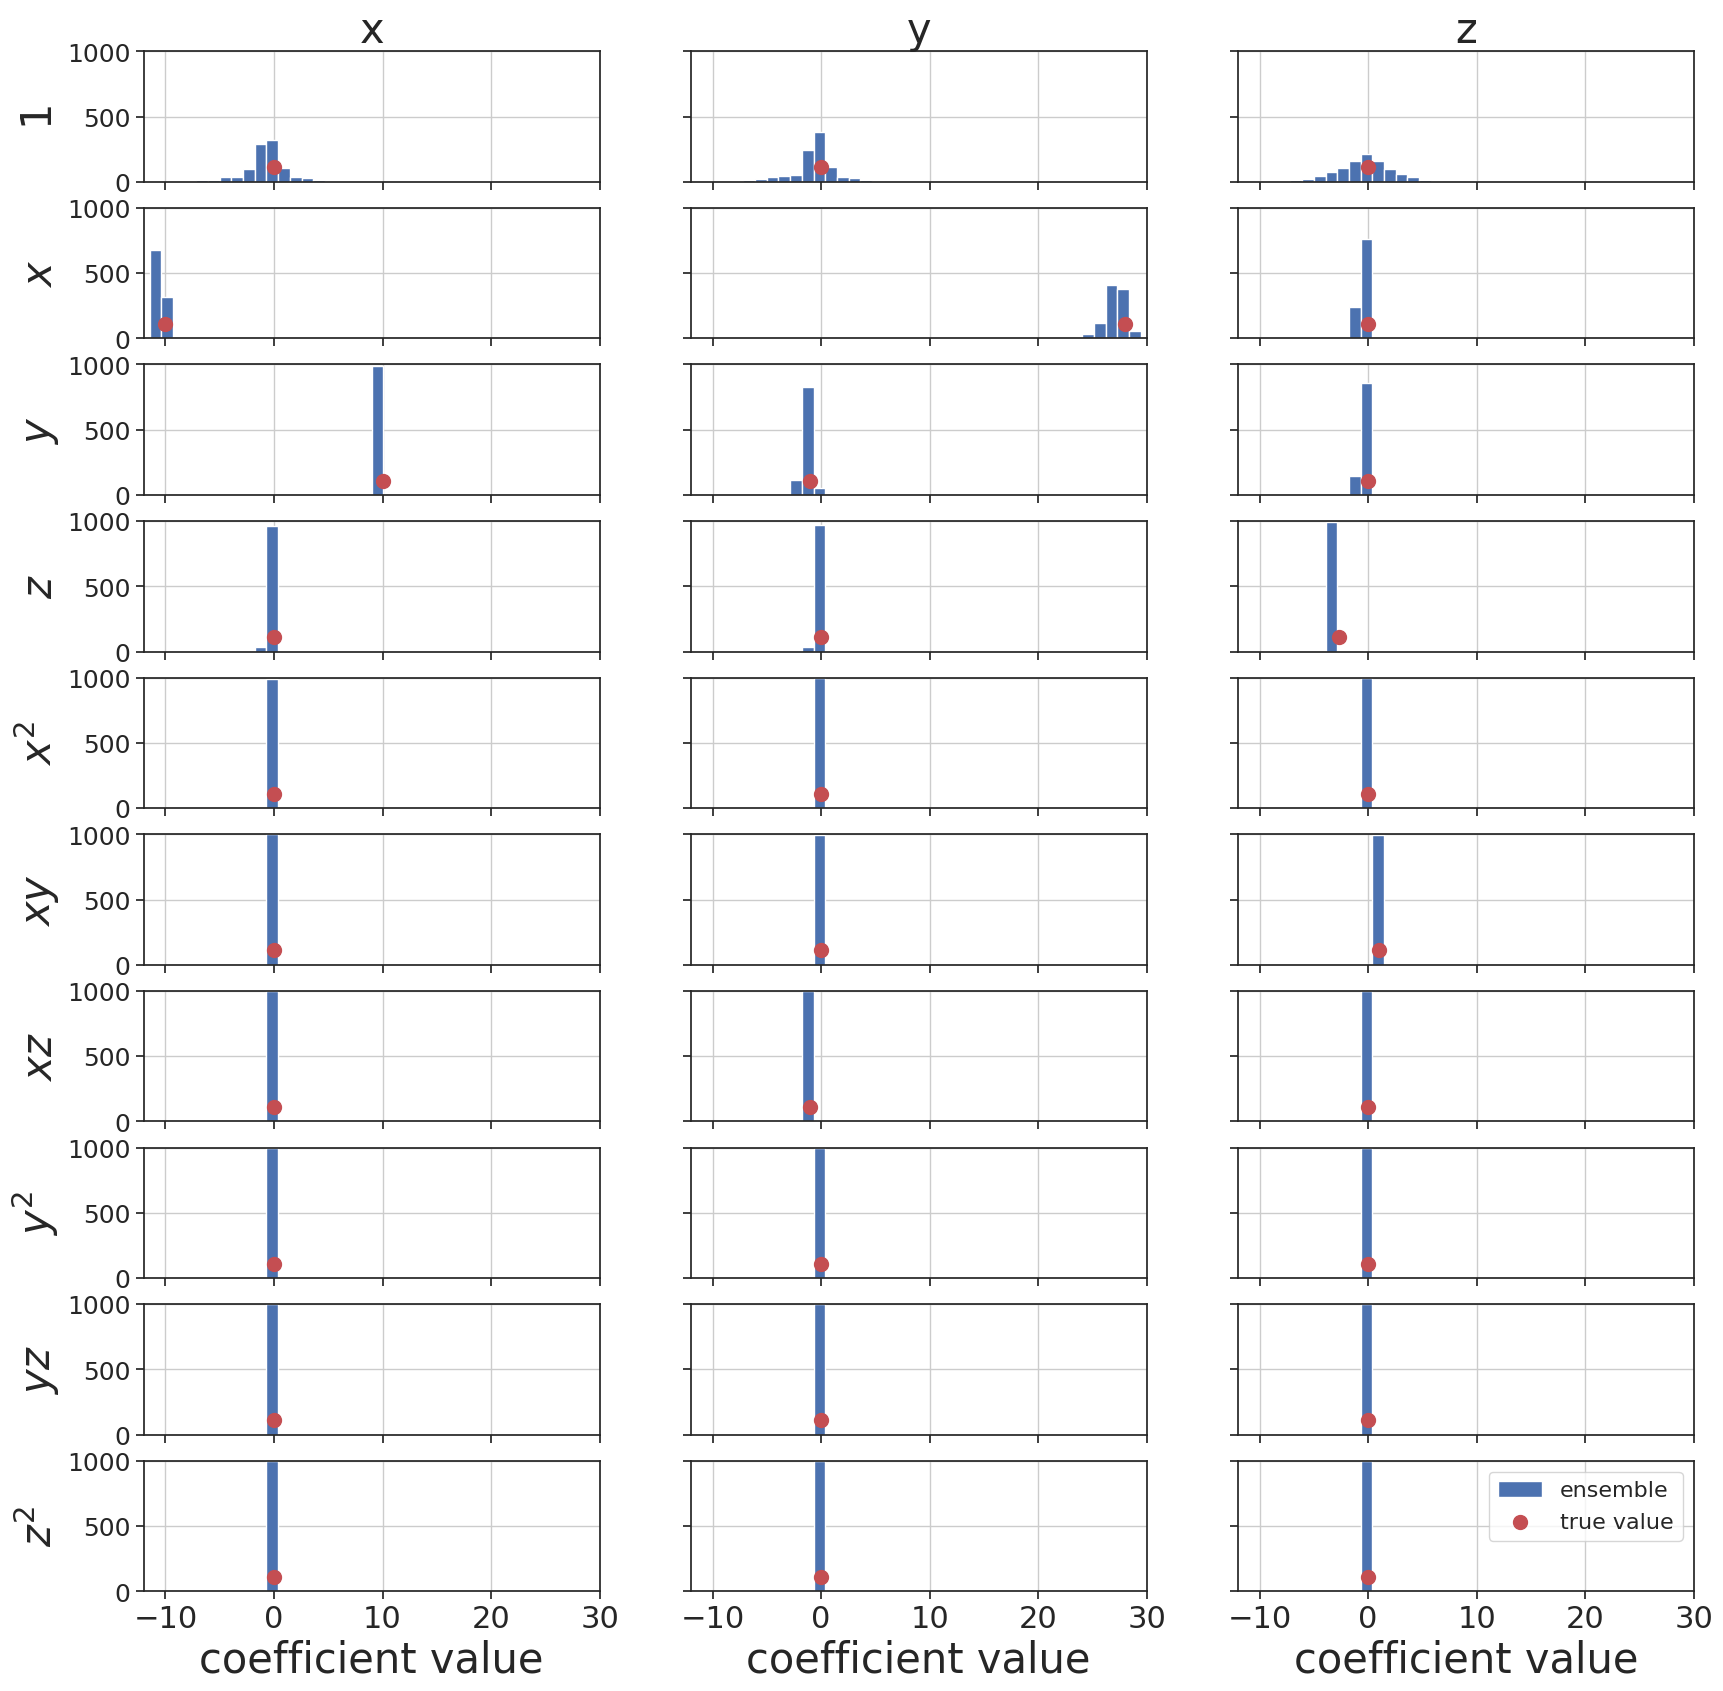

In [5]:
# Fit the ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(x_train, dt, n_models=1000)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

OK! This is consistent with results reported [here](https://pysindy.readthedocs.io/en/stable/examples/13_ensembling/example.html#Repeat-ensembling-but-now-make-~1000-models-and-plot-the-distributions-of-coefficients).

**NOTE**: The reason why the `coefficients` of the model do not coincide with the median of the `ensemble_coefs` is because `coefficients` are "unbiased" after the median is calculated; that is, once the non-zero terms have been decided with regularization, parameters are estimated using unregularized linear regression.

#### Low (but not *very* low) noise

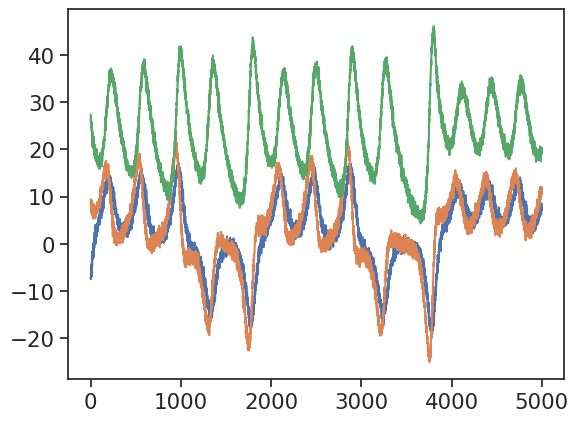

In [6]:
x_train, dt = generate_lorenz_data(0.05)
plot_data(x_train)

(x)' = -3.838 1 + -1.368 x + 4.977 y + 0.082 x^2 + -0.201 x y + -0.224 x z + 0.113 y^2 + 0.124 y z
(y)' = 0.715 1 + 26.152 x + -0.474 y + -0.009 x^2 + -0.956 x z
(z)' = -4.242 1 + 0.478 x + -0.360 y + -2.451 z + 0.857 x y + 0.094 y^2
[[-3.83751985e+00 -1.36797750e+00  4.97720787e+00  0.00000000e+00
   8.18582509e-02 -2.01450216e-01 -2.23937636e-01  1.12814107e-01
   1.24309492e-01  0.00000000e+00]
 [ 7.14961174e-01  2.61519894e+01 -4.73703449e-01  0.00000000e+00
  -8.74468542e-03  0.00000000e+00 -9.56430766e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.24236884e+00  4.78291831e-01 -3.59859012e-01 -2.45062005e+00
   0.00000000e+00  8.56787909e-01  0.00000000e+00  9.44086008e-02
   0.00000000e+00  0.00000000e+00]]
[[-1.13870436 -1.45277157  5.02424361  0.          0.12511817 -0.22086564
  -0.21819987  0.10231912  0.13272007  0.        ]
 [ 1.26128381 23.31030037  1.29274035  0.         -0.16919145  0.
  -0.87510706  0.          0.          0.        ]
 [ 2.13367446  1.04350

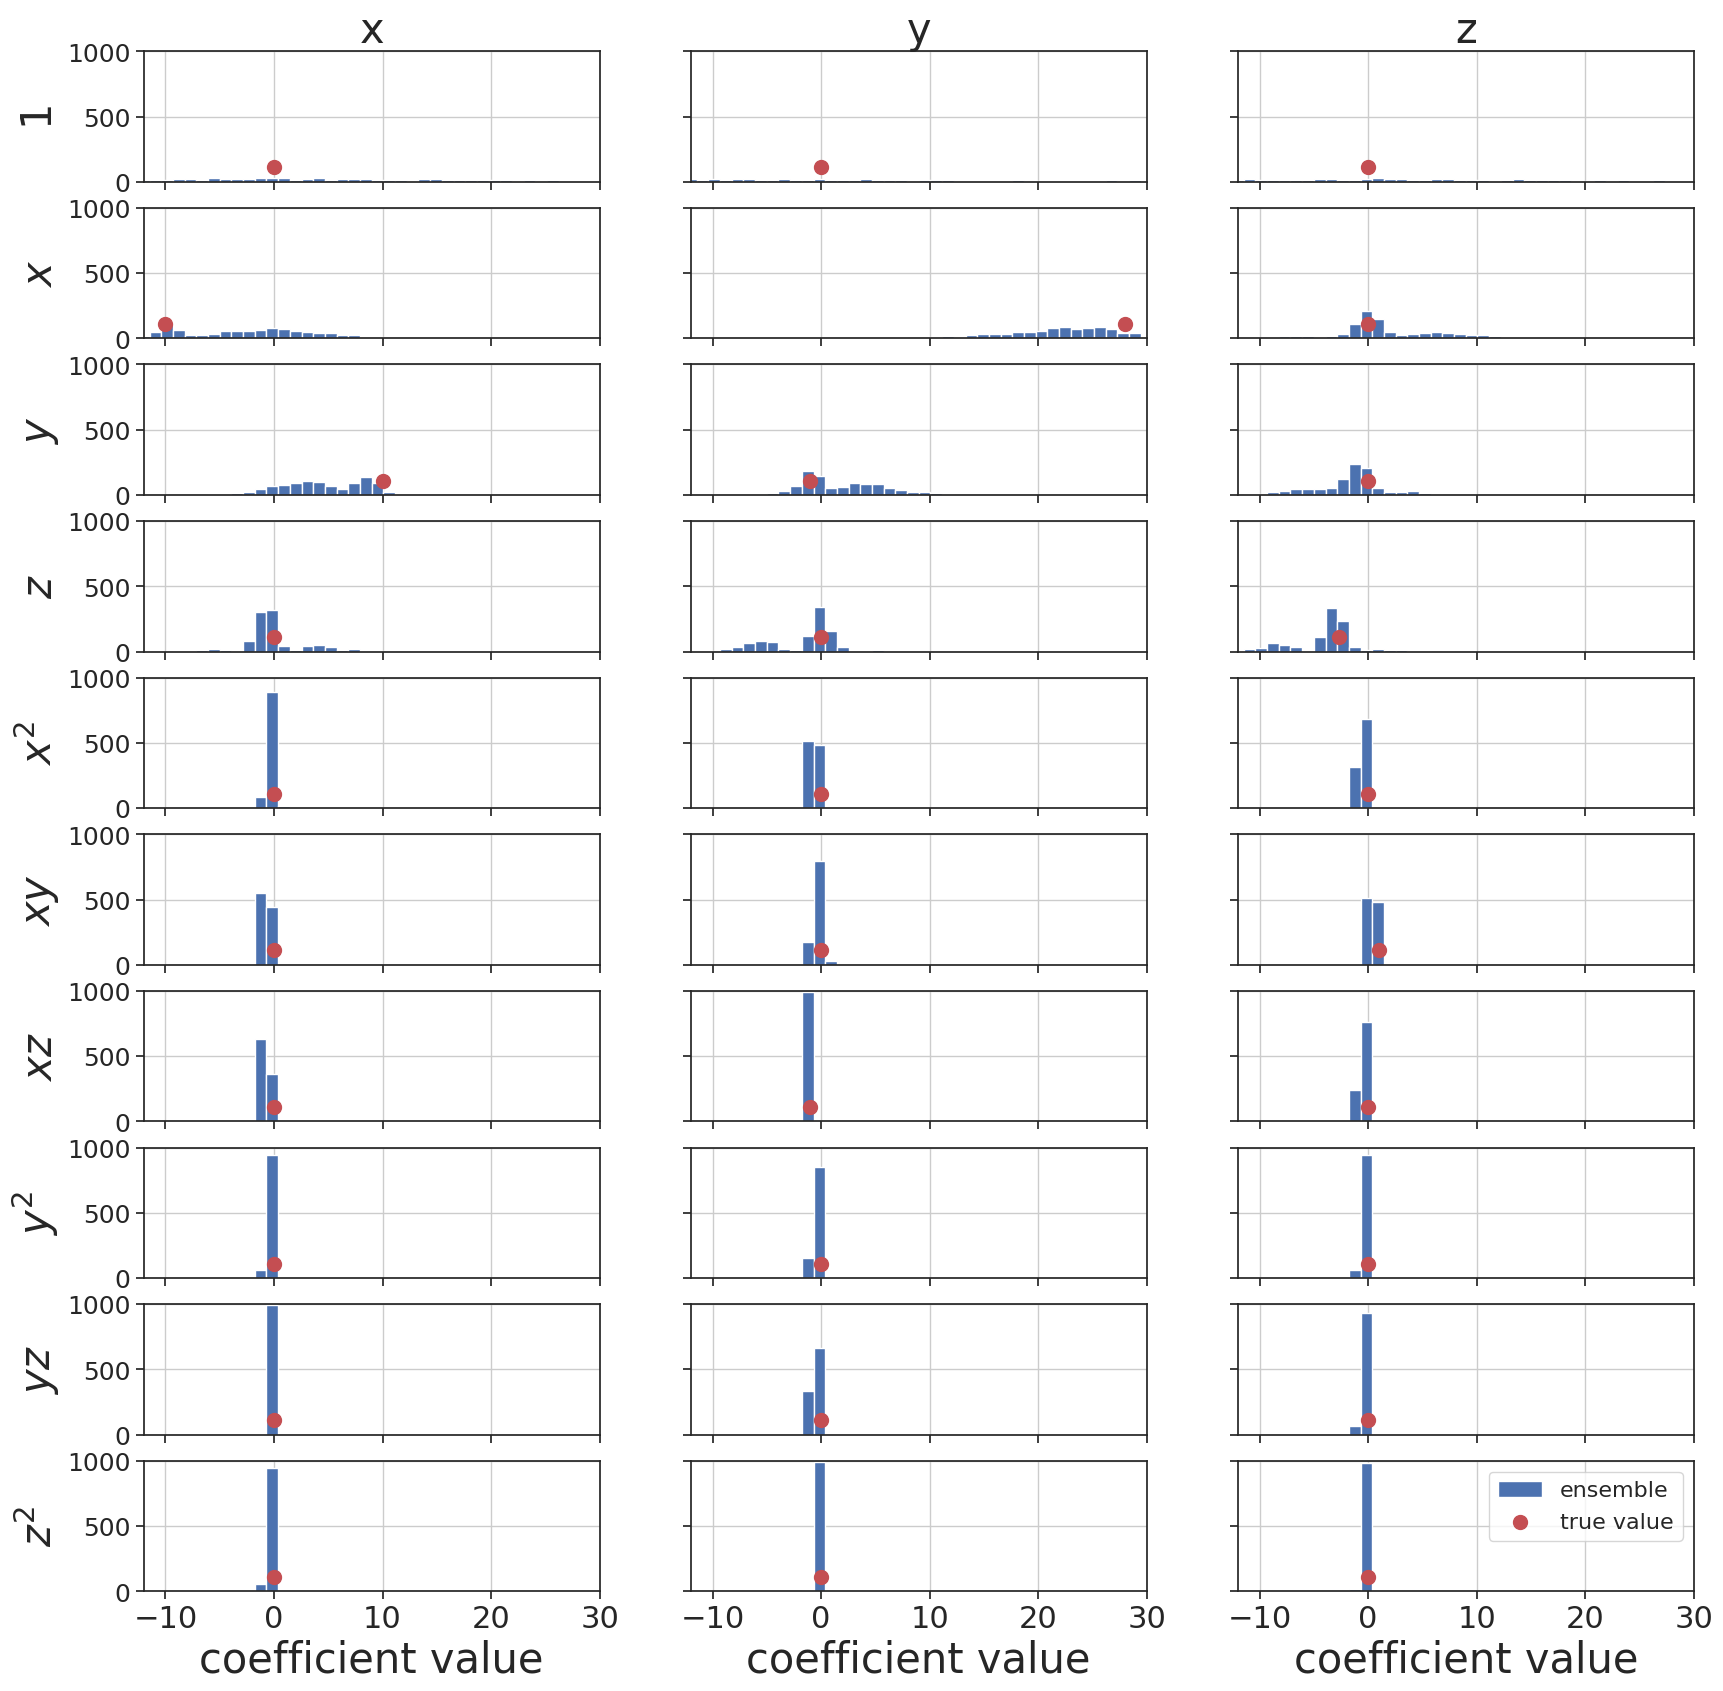

In [7]:
# Fit the ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(x_train, dt, n_models=1000)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Some estimates are starting to be really wrong (e.g. bias term) :(

## Logistic growth

$$\dot{x} = x (1 - x)$$

In [8]:
# Read data
def read_logistic_data(fname):
    data = pd.read_pickle('Data/logistic_noise_data/' + fname)
    # Check if data are equispaced in time
    ts = data.t
    dt = ts[1] - ts[0]
    # Add the FD derivative to the data
    data['B_dot'] = ps.FiniteDifference()._differentiate(data.B.to_numpy(), t=dt)
    # Get the noise level from the file name!
    sigma = float(fname.split('_')[0])
    # Done
    return data, sigma, dt

#### Very low noise

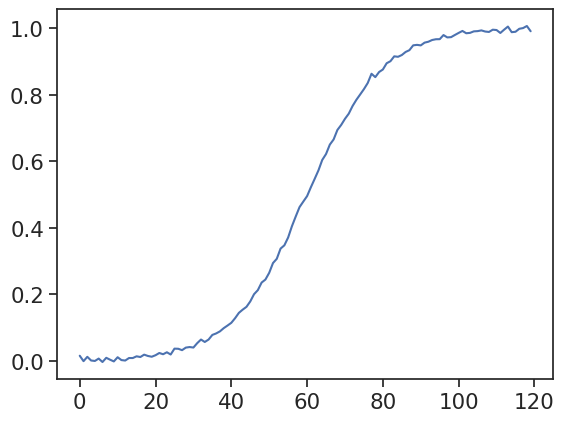

In [9]:
data, sigma, dt = read_logistic_data('0.005_0.pkl')
x_train = data.B.to_numpy().reshape((len(data.B), 1))
plot_data(x_train)

(x)' = 1.011 x + -1.018 x^2
[[ 0.          1.01129793 -1.01776992]]
[[ 0.          0.94279118 -0.94140954]]
['x', 'x^2']


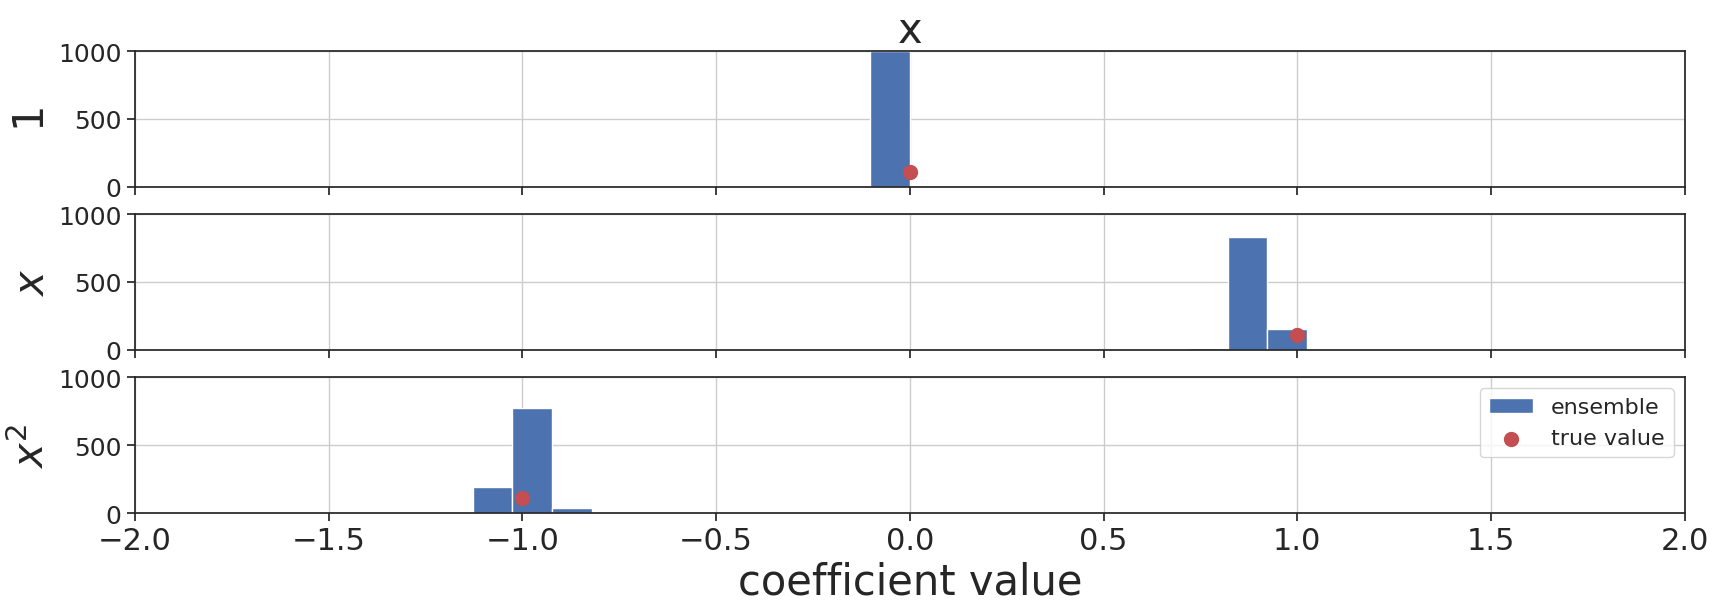

In [10]:
# Fit the ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(x_train, dt, n_models=1000)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

#### Low (but not *very* low) noise

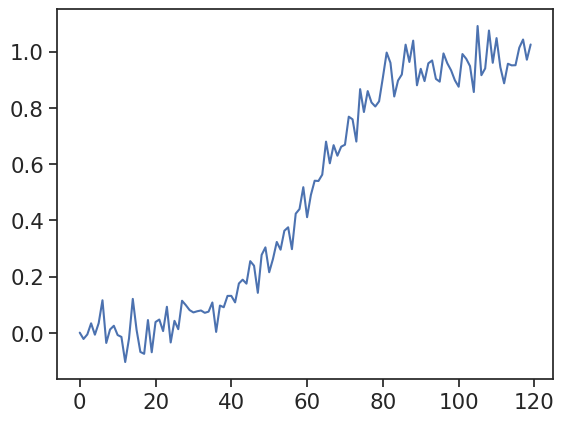

In [11]:
data, sigma, dt = read_logistic_data('0.05_0.pkl')
x_train = data.B.to_numpy().reshape((len(data.B), 1))
plot_data(x_train)

(x)' = 0.739 x + -0.686 x^2
[[ 0.          0.738634   -0.68610898]]
[[ 0.          0.67777774 -0.62641383]]
['x', 'x^2']


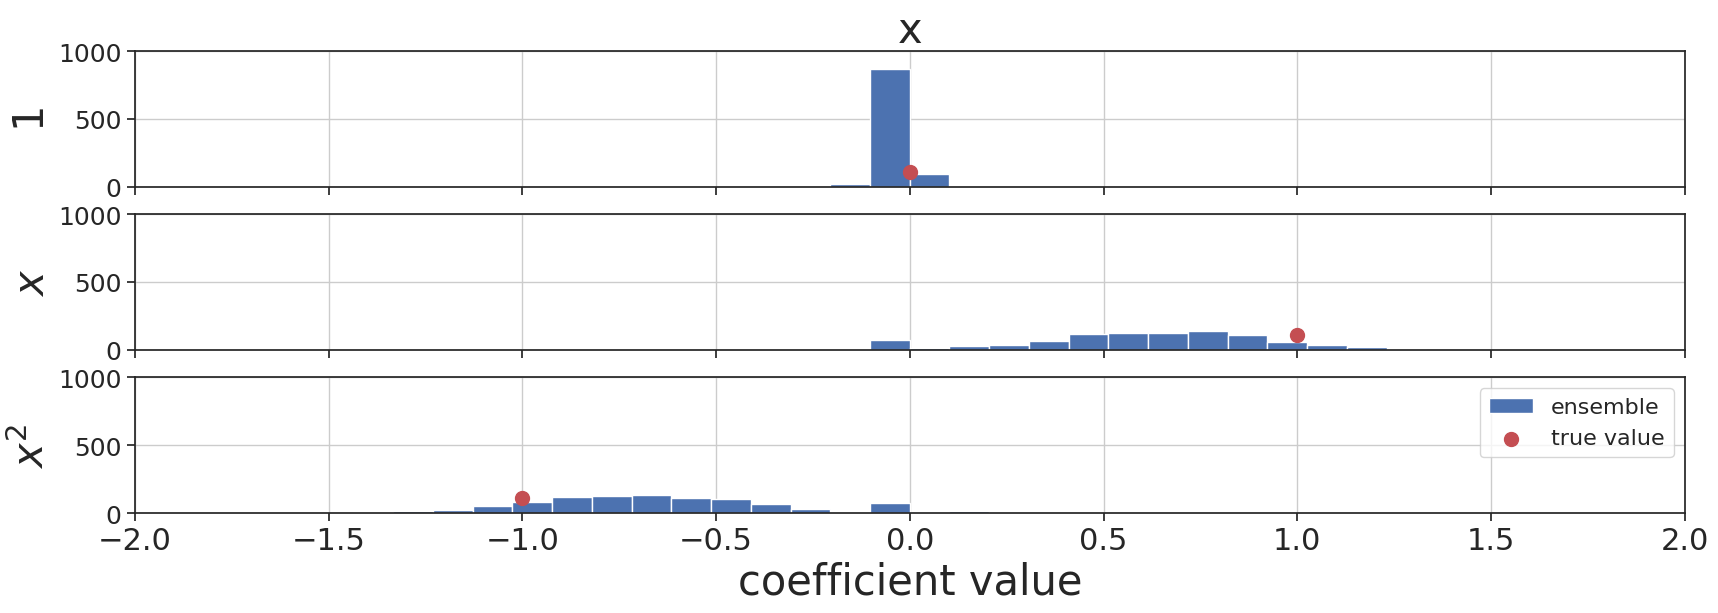

In [12]:
# Fit the ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(x_train, dt, n_models=1000)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(model.coef_list, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Parameter estimations are clearly biased, but SINDy still gets the result right because the library functions are highly restricted.

#### Very low noise *and* larger libraries

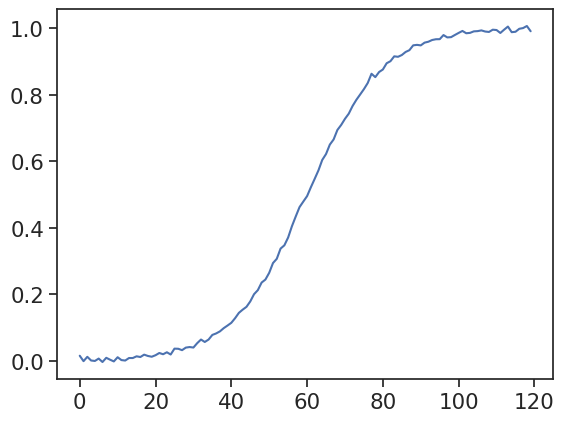

In [13]:
data, sigma, dt = read_logistic_data('0.005_0.pkl')
x_train = data.B.to_numpy().reshape((len(data.B), 1))
plot_data(x_train)

(x)' = 0.980 x + -0.918 x^2 + -0.070 x^3
[[ 0.          0.97965149 -0.91821891 -0.06951828  0.        ]]
[[ 0.          0.7680694  -0.36130466 -0.36219655  0.        ]]
['x', 'x^2', 'x^3']


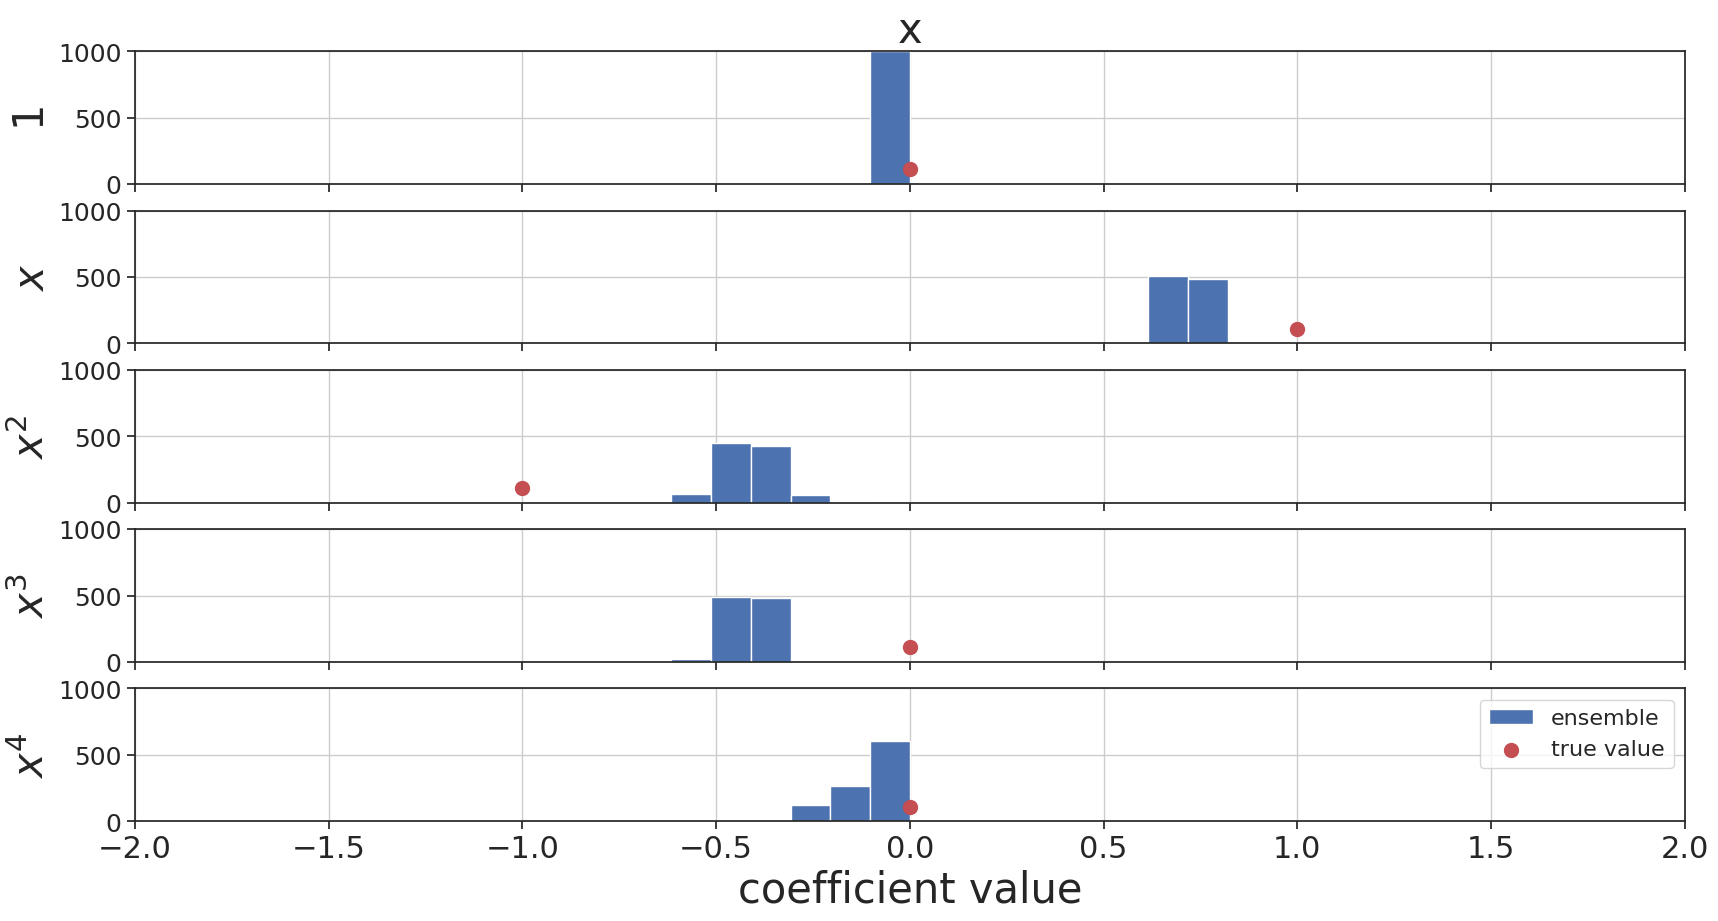

In [14]:
# Fit the ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(x_train, dt, n_models=1000, max_degree=4)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(model.coef_list, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Even in this very low-noise scenario it gets it wrong! :_(

The relatively good news is that the wrong term is relatively small, once unbiased.

#### Moderate noise regime with large library

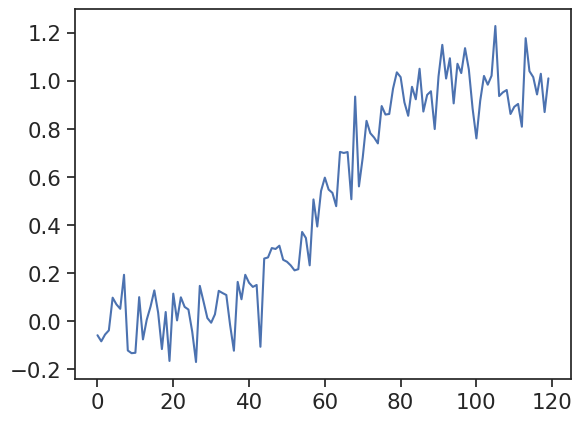

In [15]:
data, sigma, dt = read_logistic_data('0.1_0.pkl')
x_train = data.B.to_numpy().reshape((len(data.B), 1))
plot_data(x_train)

(x)' = -0.276 x + 5.542 x^2 + -9.892 x^3 + 4.676 x^4
[[ 0.         -0.27639933  5.54173059 -9.89189403  4.67579637]]
[[ 0.          0.30525043  0.35038957 -1.05681476  0.46737082]]
['x', 'x^2', 'x^3', 'x^4']


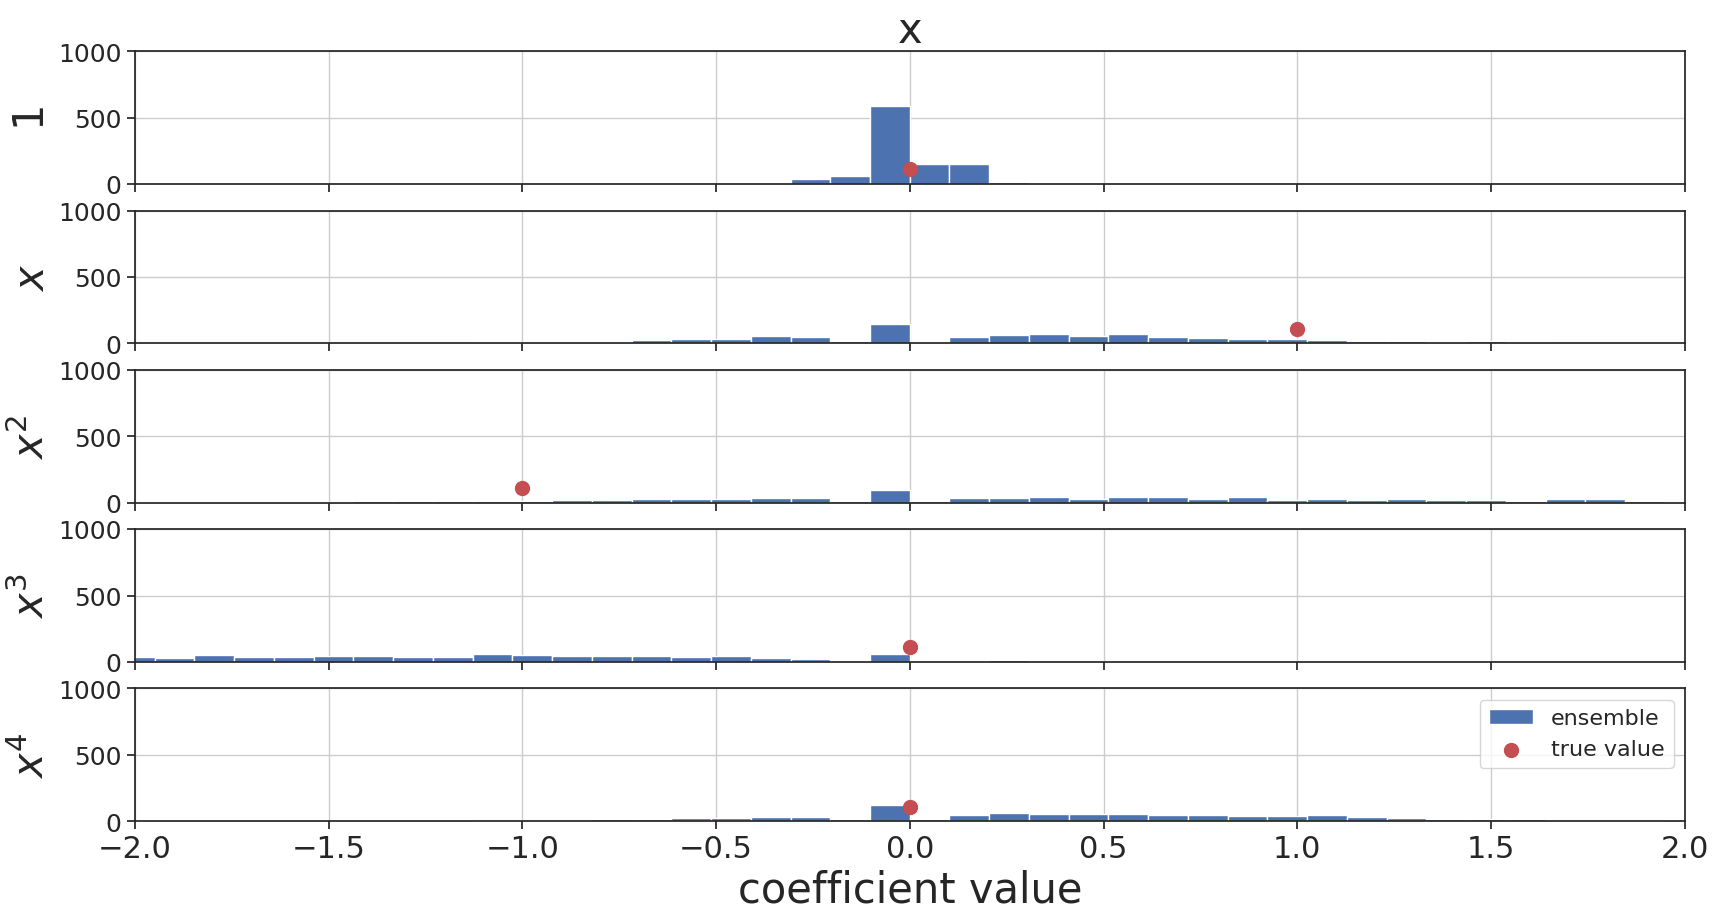

In [16]:
# Fit the ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(x_train, dt, n_models=1000, max_degree=4)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(model.coef_list, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Mmmmmmmm :(

# Weak formulation

Our implementation follows [this PySINDy tutorial](https://pysindy.readthedocs.io/en/stable/examples/12_weakform_SINDy_examples/example.html#Test-weak-form-ODE-functionality-on-Lorenz-equation).

In [17]:
# Not very elegant, I know...
def get_library(n_feat, max_degree=2):
    # Logistic
    if n_feat == 1:
        if max_degree == 2:
            library_functions = [
                lambda x: x,
                lambda x: x * x,
            ]
            library_names = [
                lambda x: x,
                lambda x: f'{x}^2',
            ]
        elif max_degree == 3:
            library_functions = [
                lambda x: x, lambda x: x * x, lambda x: x * x * x,
            ]
            library_names = [
                lambda x: x, lambda x: f'{x}^2', lambda x: f'{x}^3',
            ]
        elif max_degree == 4:
            library_functions = [
                lambda x: x,
                lambda x: x * x,
                lambda x: x * x * x,
                lambda x: x * x * x * x,
            ]
            library_names = [
                lambda x: x,
                lambda x: f'{x}^2',
                lambda x: f'{x}^3',
                lambda x: f'{x}^4',
            ]
        else:
            raise ValueError

    # Lotka-Volterra
    elif n_feat == 2:
        if max_degree == 2:
            library_functions = [
                lambda x: x,
                lambda x: x * x,
                lambda x, y: x * y,
            ]
            library_names = [
                lambda x: x,
                lambda x: f'{x}^2',
                lambda x, y: x + y,
            ]
        elif max_degree == 3:
            library_functions = [
                lambda x: x, lambda x: x * x, lambda x: x * x * x,
                lambda x, y: x * y,
                lambda x, y: x * x * y, lambda x, y: x * y * y, 
            ]
            library_names = [
                lambda x: x, lambda x: f'{x}^2', lambda x: f'{x}^3',
                lambda x, y: x + y,
                lambda x, y: f'{x}^2' + y, lambda x, y: x + f'{y}^2',
            ]
        elif max_degree == 4:
            library_functions = [
                lambda x: x,
                lambda x: x * x,
                lambda x: x * x * x,
                lambda x: x * x * x * x,
                lambda x, y: x * y,
                lambda x, y: x * x * y, 
                lambda x, y: x * x * y * y, 
                lambda x, y: x * x * x * y, 
            ]
            library_names = [
                lambda x: x,
                lambda x: f'{x}^2',
                lambda x: f'{x}^3',
                lambda x: f'{x}^4',
                lambda x, y: x + y,
                lambda x, y: f'{x}^2' + y,
                lambda x, y: f'{x}^2' + f'{y}^2',
                lambda x, y: f'{x}^3' + y,
            ]

    # Lorenz
    elif n_feat == 3:
        if max_degree == 2:
            library_functions = [
                lambda x: x,
                lambda x: x * x,
                lambda x, y: x * y,
            ]
            library_names = [
                lambda x: x,
                lambda x: f'{x}^2',
                lambda x, y: x + y,
            ]
        elif max_degree == 3:
            library_functions = [
                lambda x: x, lambda x: x * x, lambda x: x * x * x,
                lambda x, y: x * y, lambda x, y: x * x * y, 
                lambda x, y, z: x * y * z, 
            ]
            library_names = [
                lambda x: x, lambda x: f'{x}^2', lambda x: f'{x}^3',
                lambda x, y: x + y, lambda x, y: f'{x}^2' + y,
                lambda x, y, z: x + y + z,
            ]
        elif max_degree == 4:
            library_functions = [
                lambda x: x,
                lambda x: x * x,
                lambda x: x * x * x,
                lambda x: x * x * x * x,
                lambda x, y: x * y,
                lambda x, y: x * x * y, 
                lambda x, y: x * x * y * y, 
                lambda x, y: x * x * x * y, 
                lambda x, y, z: x * y * z, 
                lambda x, y, z: x * x * y * z, 
            ]
            library_names = [
                lambda x: x,
                lambda x: f'{x}^2',
                lambda x: f'{x}^3',
                lambda x: f'{x}^4',
                lambda x, y: x + y,
                lambda x, y: f'{x}^2' + y,
                lambda x, y: f'{x}^2' + f'{y}^2',
                lambda x, y: f'{x}^3' + y,
                lambda x, y, z: x + y + z,
                lambda x, y, z: f'{x}^2' + y + z,
            ]
        else:
            raise ValueError
    else:
        raise ValueError
    return library_functions, library_names
           
        

In [18]:
# Fit ensemble model using the weak formulation
def fit_weak_ensemble_sindy(
    x_train, t_train,
    n_models=1000,
    max_degree=2,
    threshold=0.1,
):
    feature_names = ['x', 'y', 'z'][:len(x_train[0])]
    ensemble_optimizer = ps.STLSQ(threshold=threshold)
    
    # Weak library
    library_functions, library_function_names = get_library(
        len(feature_names), max_degree,
    )
    weak_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        include_bias=True,
        spatiotemporal_grid=t_train,
        is_uniform=True,
        K=1000,
    )

    # SINDy initialization
    model = ps.SINDy(
        feature_names=feature_names,
        feature_library=weak_lib,
        optimizer=ensemble_optimizer,
    )
    model.fit(
        x_train,
        ensemble=True,
        n_models=n_models,
        quiet=True
    )
    ensemble_coefs = np.asarray(model.coef_list)

    # Done
    return model, ensemble_coefs

## Lorenz wiht moderate noise

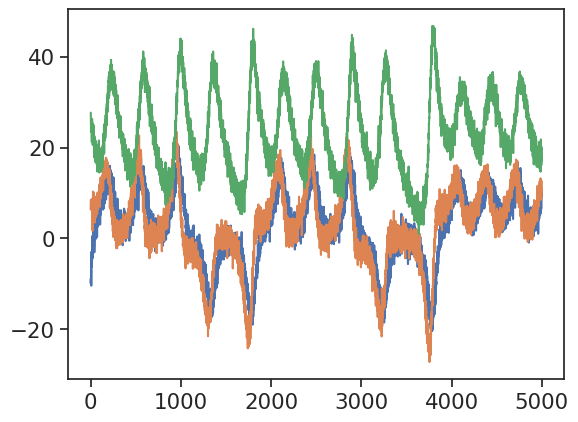

In [19]:
x_train, dt, t_train = generate_lorenz_data(0.10, t_series=True)
plot_data(x_train)

#### Regular (non-integral) ensemble SINDy

(x)' = -8.939 1 + 3.618 x + 1.190 y + 0.526 z + -0.212 x^2 + 0.328 x y + -0.357 x z + -0.144 y^2 + 0.222 y z
(y)' = -23.591 1 + 17.441 x + 3.871 y + 1.686 z + -0.566 x^2 + 0.773 x y + -0.717 x z + -0.303 y^2 + -0.124 y z
(z)' = -17.938 1 + -0.167 x + -0.296 y + -1.720 z + 0.615 x y + 0.242 y^2
[[ -8.93873191   3.61844526   1.19021675   0.52595776  -0.21159457
    0.32773029  -0.35651776  -0.14359776   0.22154275   0.        ]
 [-23.5913438   17.4414893    3.87102018   1.68564438  -0.56613036
    0.77320596  -0.7170286   -0.30258731  -0.12360298   0.        ]
 [-17.9384501   -0.16666768  -0.29555772  -1.7196828    0.
    0.61459568   0.           0.24212141   0.           0.        ]]
[[-4.21568087  3.14156484  1.68850929  0.29825023 -0.18654698  0.33693177
  -0.34231494 -0.14095182  0.20853105  0.        ]
 [-3.00403607 17.85346908  3.63285185  0.36471155 -0.68570071  0.8510772
  -0.72161464 -0.32040486 -0.12539188  0.        ]
 [-9.5519199  -2.42668396  0.72731301 -2.26370432  0.     

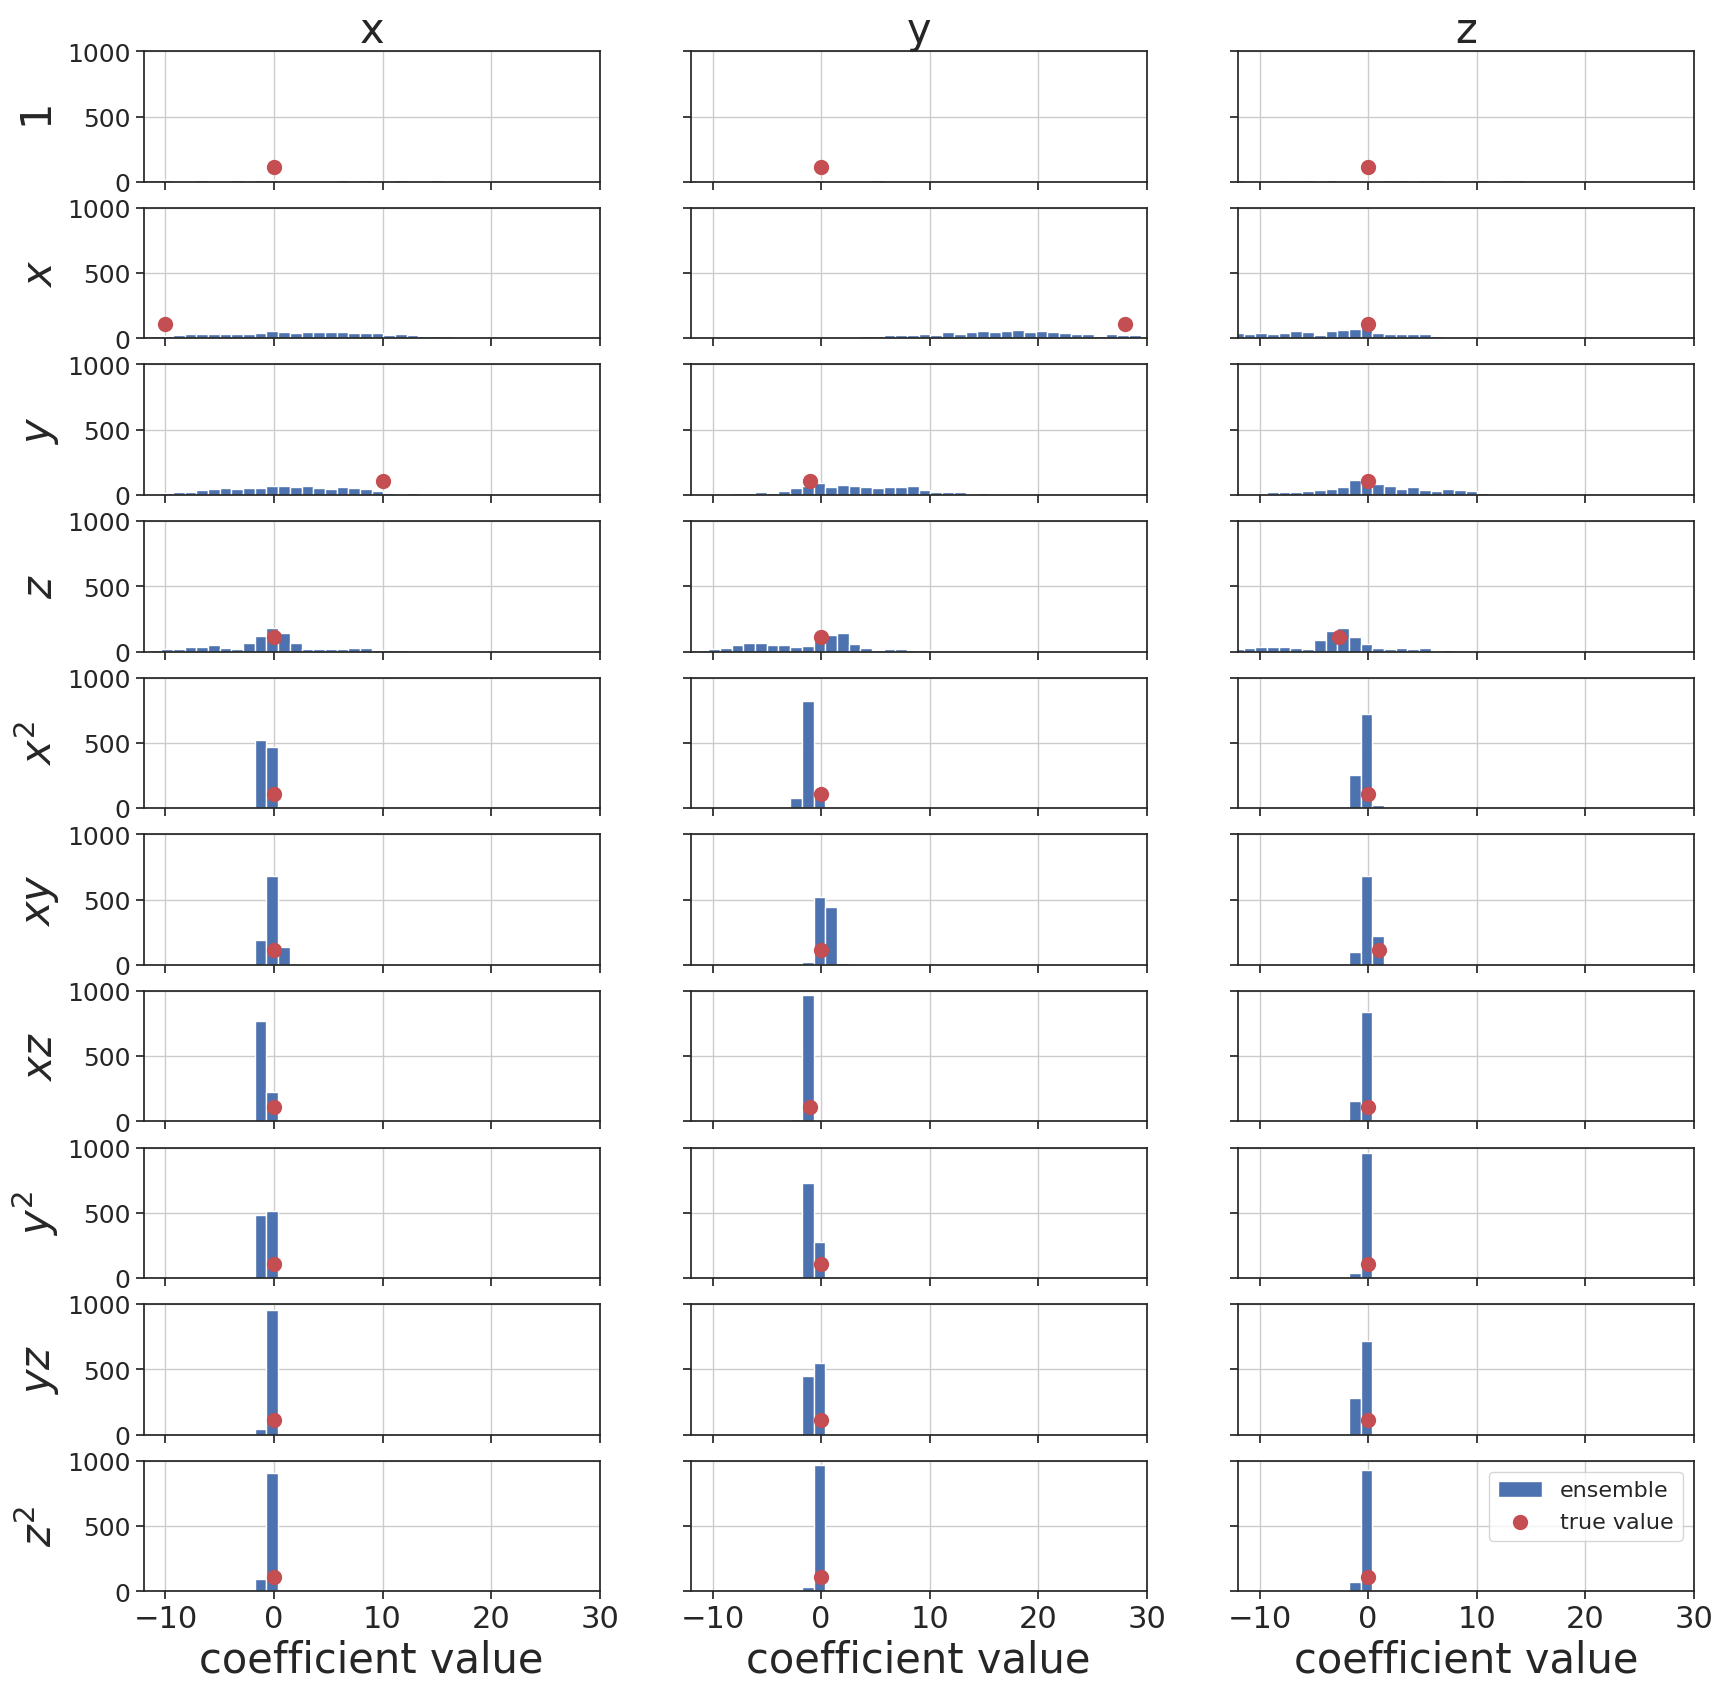

In [20]:
# Fit the REGULAR ensemble SINDy
model, ensemble_coefs = fit_ensemble_sindy(
    x_train, dt, n_models=1000
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

As expected, this level of noise is way too much for regular SINDy, so let's check if the weak/integral formulation can handle it...

#### Weak (integral) SINDy

(x)' = 0.228 1 + -9.852 x + 9.839 y
(y)' = -0.624 1 + 27.372 x + -0.782 y + -0.985 xz
(z)' = -0.263 1 + -0.101 x + -2.647 z + 1.003 xy
[[ 0.22845888 -9.85223218  9.83937204  0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.62389934 27.37187751 -0.78218024  0.          0.          0.
   0.          0.         -0.98457905  0.        ]
 [-0.26316939 -0.10065877  0.         -2.64652353  0.          0.
   0.          1.00264046  0.          0.        ]]
[[ 0.22889355 -9.85218762  9.83915358  0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.62099071 27.34179699 -0.77261964  0.          0.          0.
   0.          0.         -0.98384276  0.        ]
 [-0.20723523 -0.10053389  0.         -2.64926978  0.          0.
   0.          1.00310188  0.          0.        ]]
['1', 'x', 'y', '1', 'x', 'y', 'xz', '1', 'x', 'z', 'xy']


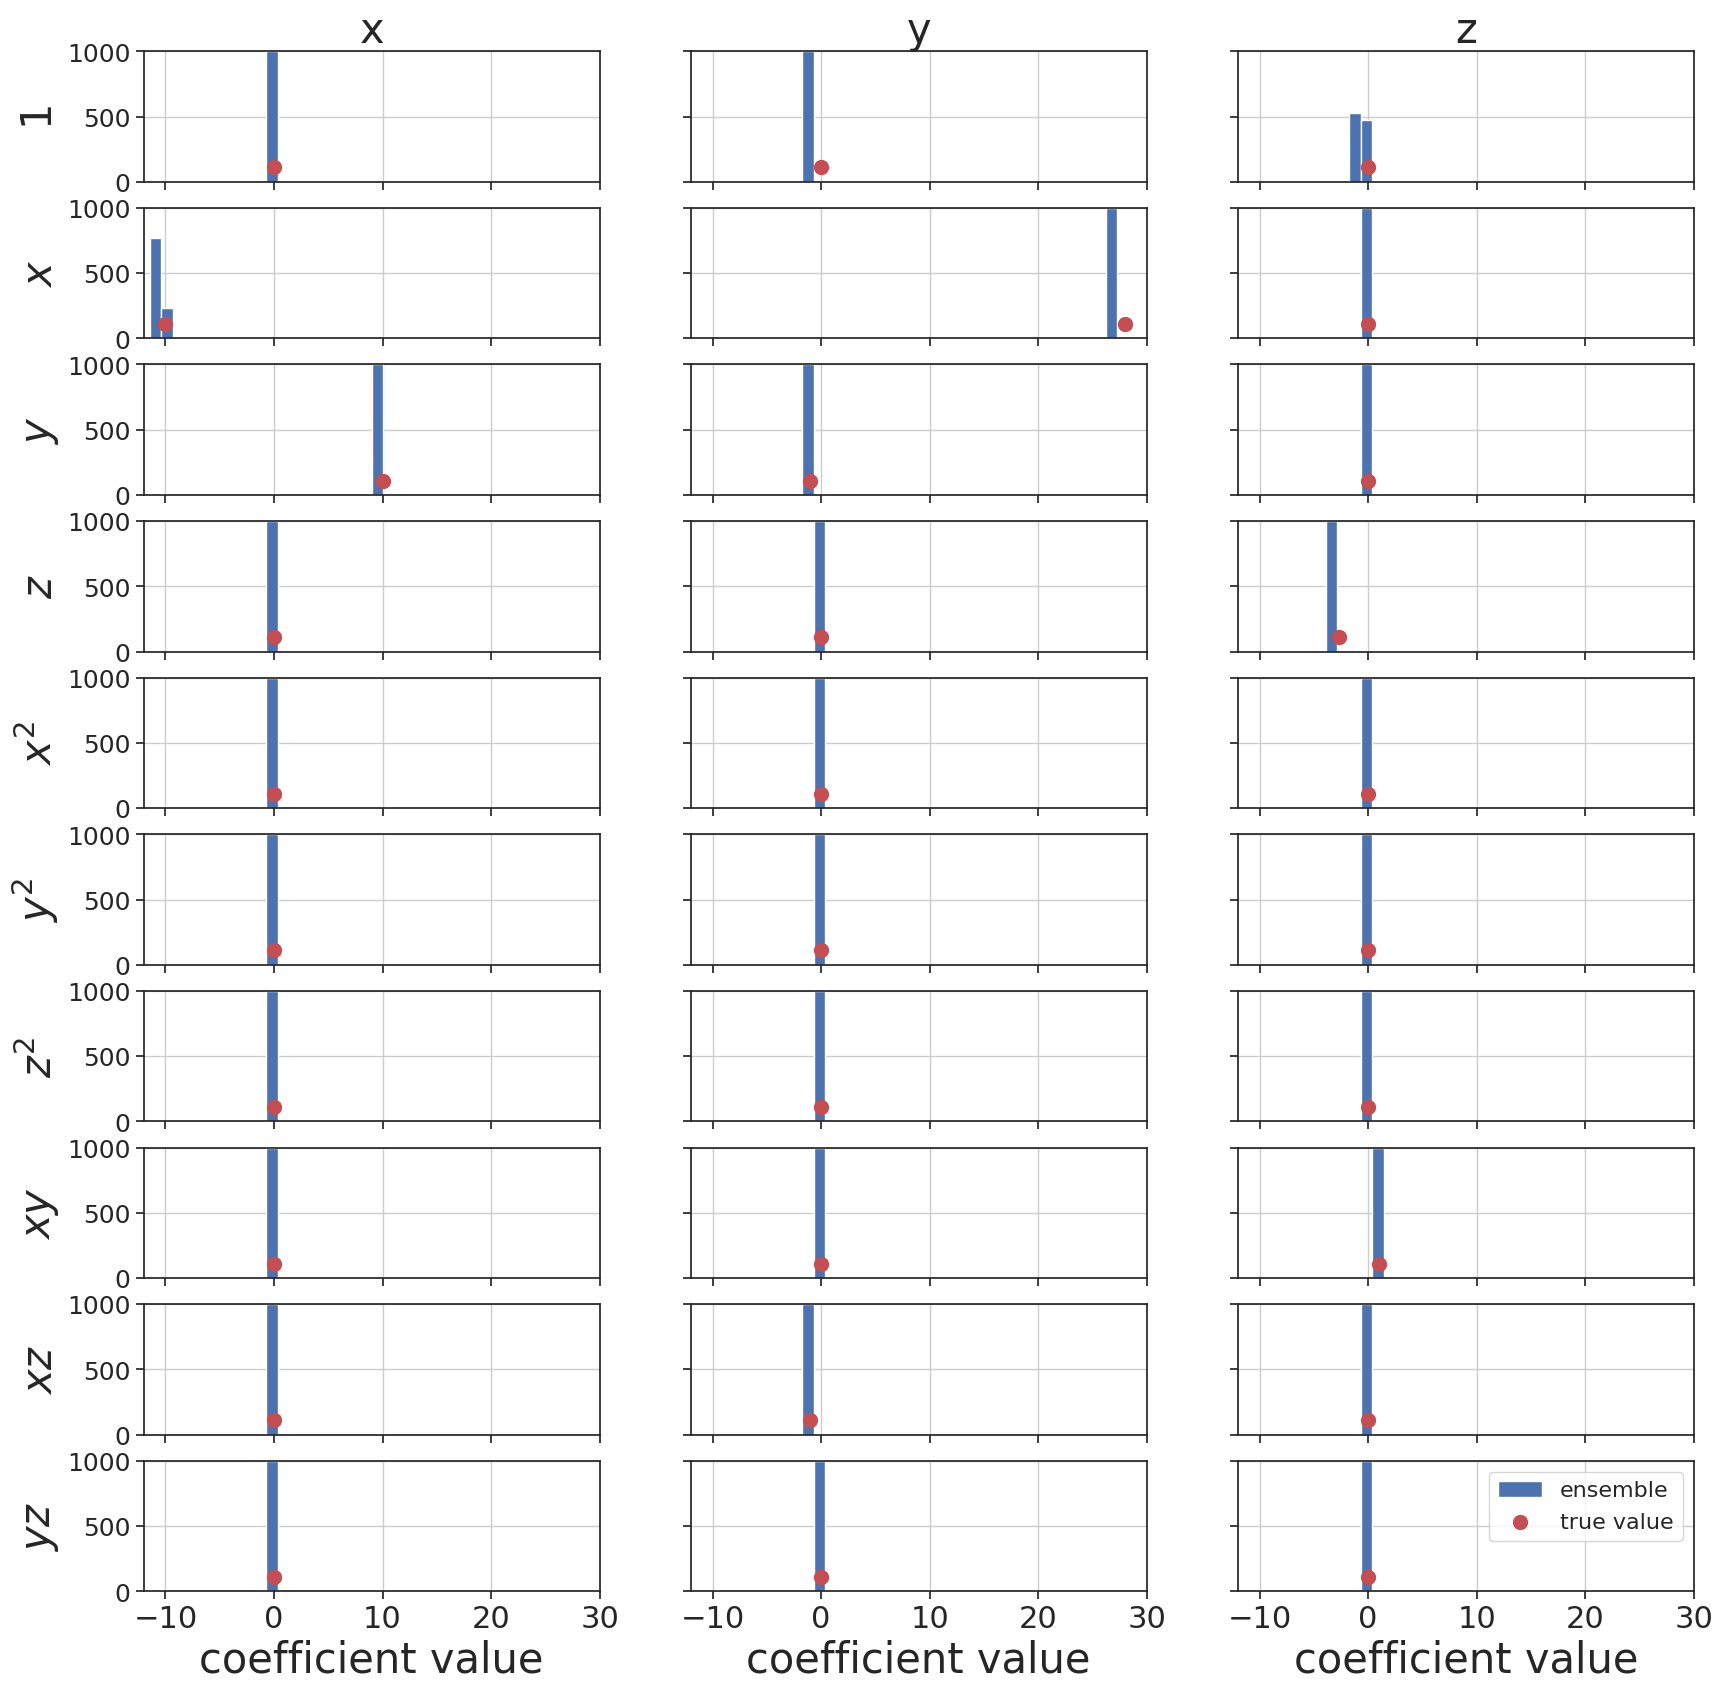

In [21]:
# Fit the WEAK ensemble SINDy
model, ensemble_coefs = fit_weak_ensemble_sindy(
    x_train, t_train, max_degree=2, n_models=1000
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

OK, as expected from the [online tutorial](https://www.youtube.com/watch?v=_iBjhpryUc4&list=PLN90bHJU-JLoOfEk0KyBs2qLTV7OkMZ25&index=6), at this level of noise there are still some extra terms, but the weak formulation mostly recovers the right parameter values.

Let's now try the same problem, but with larger libraries.

#### Weak (integral) SINDy with larger libraries

(x)' = 0.206 1 + -9.865 x + 9.848 y
(y)' = -15.925 1 + -7.558 x + 15.487 y + 1.124 z + -0.314 x^2 + 0.181 y^2 + -0.376 yz
(z)' = -2.668 z + 1.002 xy
[[  0.20618523  -9.86452305   9.84776539   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.        ]
 [-15.92492479  -7.55845078  15.48678035   1.12380036  -0.31369076
    0.18143519   0.           0.           0.           0.
    0.           0.           0.           0.           0.
   -0.37630377   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.        ]
 [  0.           0.           0.          -2.66781862   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           1.00153302   0.
    0.           0

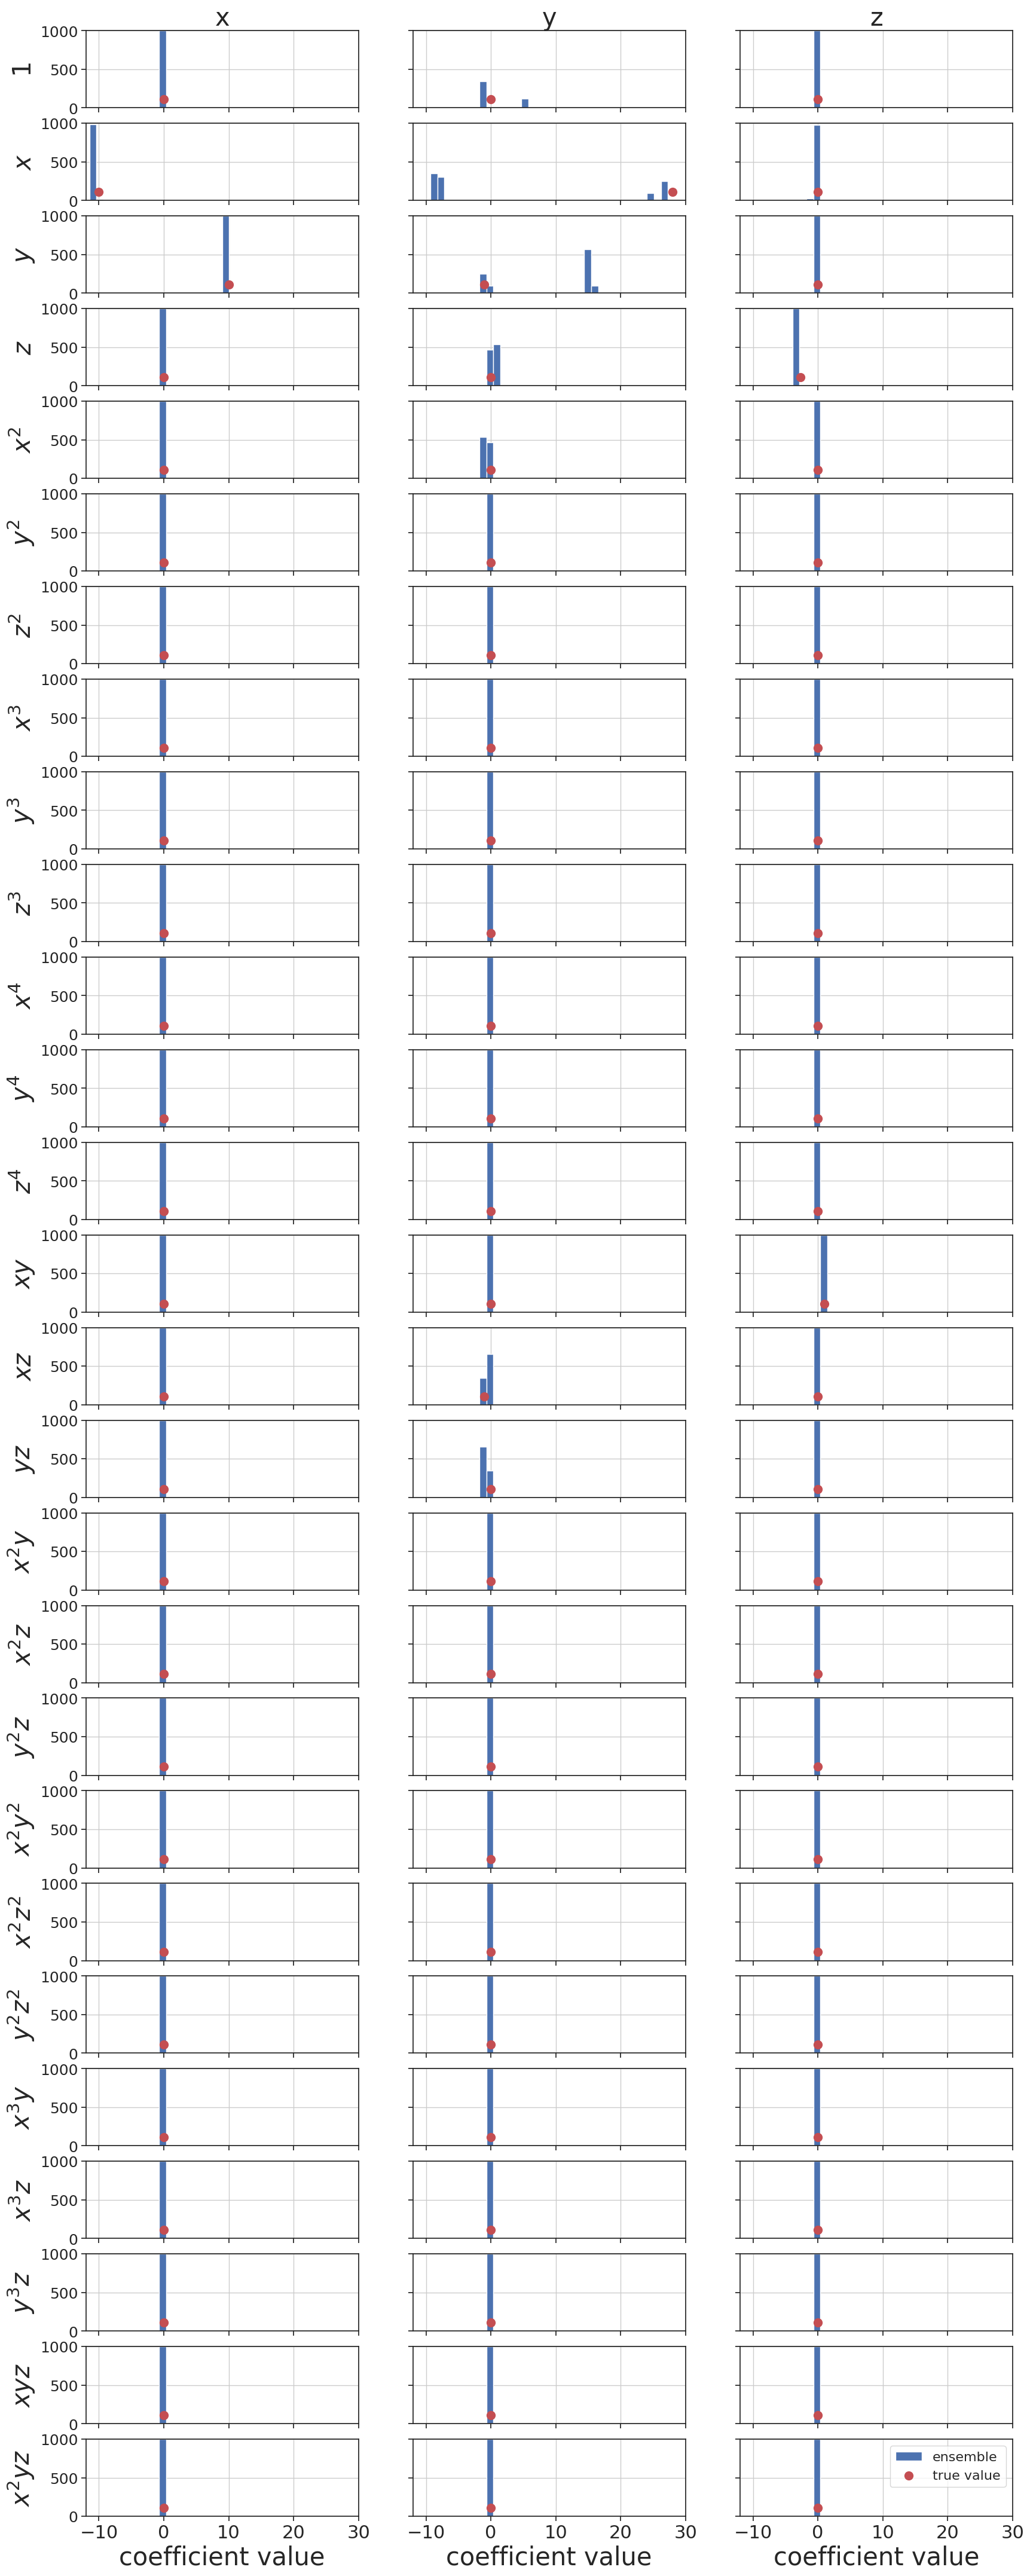

In [22]:
# Fit the WEAK ensemble SINDy
model, ensemble_coefs = fit_weak_ensemble_sindy(
    x_train, t_train, max_degree=4, n_models=1000
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

GREAT! Still (mostly) working!!!

**CAUTION**: We are still missing functions from the library, such as z^2x!!!!!!! But anyway, that's not the point!

## Logistic growth with very low noise

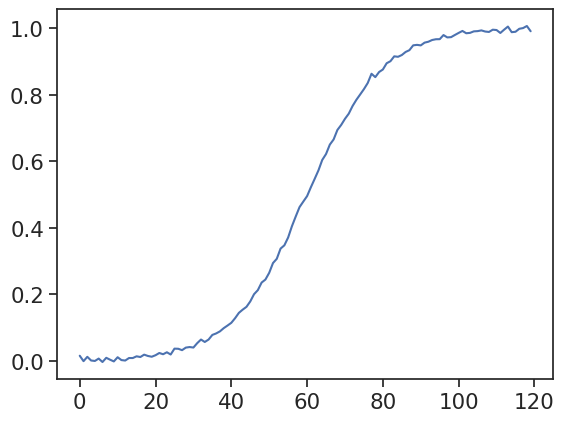

In [23]:
data, sigma, dt = read_logistic_data('0.005_0.pkl')
x_train = data.B.to_numpy().reshape((len(data.B), 1))
t_train = data.t.to_numpy().reshape((len(data.B), 1))
plot_data(x_train)

#### Weak ensemble SINDy

(x)' = 1.007 x + -1.007 x^2
[[ 0.          1.00704206 -1.00723094]]
[[ 0.          0.75639396 -0.72782735]]
['x', 'x^2']


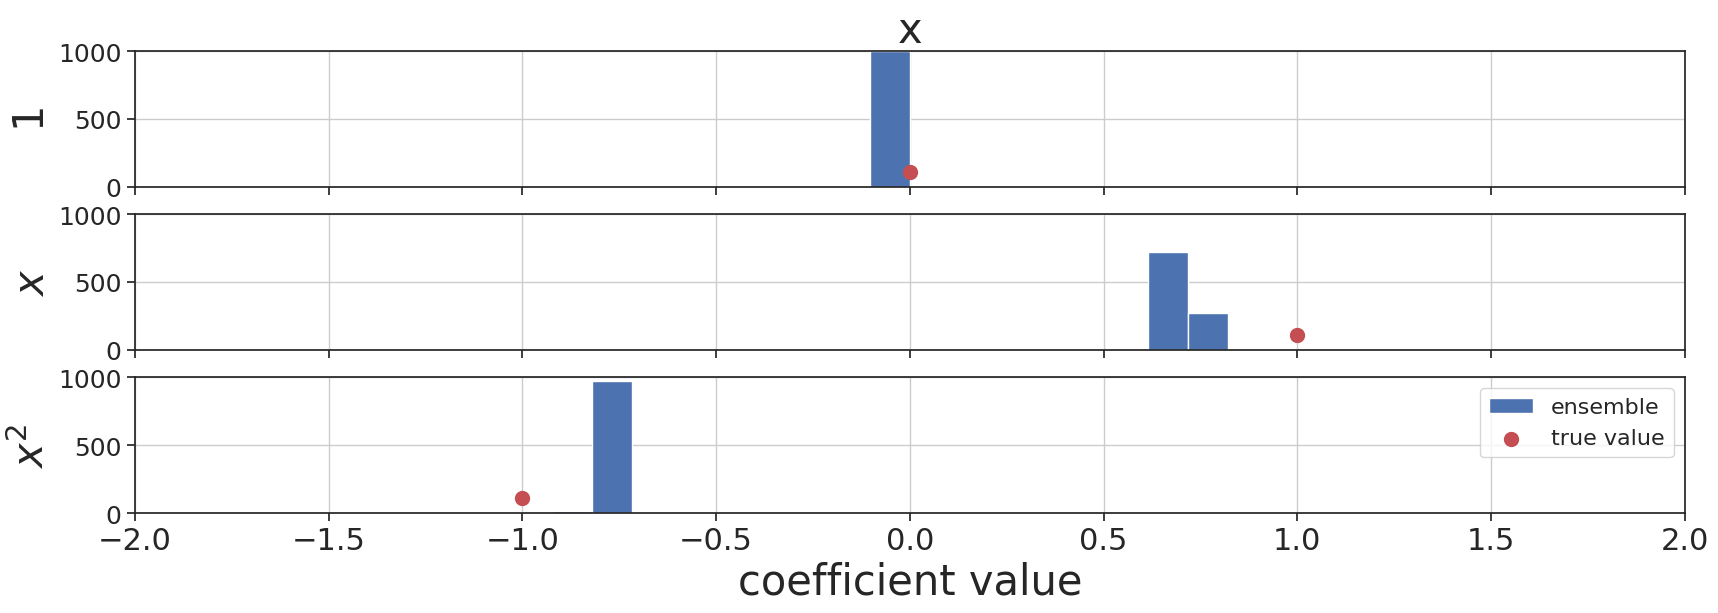

In [24]:
# Fit the WEAK ensemble SINDy
model, ensemble_coefs = fit_weak_ensemble_sindy(
    x_train, t_train, max_degree=2, n_models=1000
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Good!

#### Weak ensemble SINDy with larger library

(x)' = 0.835 x + -1.698 x^3 + 0.868 x^4
[[ 0.          0.83522147  0.         -1.6975039   0.86771118]]
[[ 0.          0.55419386  0.         -0.29819068 -0.26729286]]
['x', 'x^3', 'x^4']


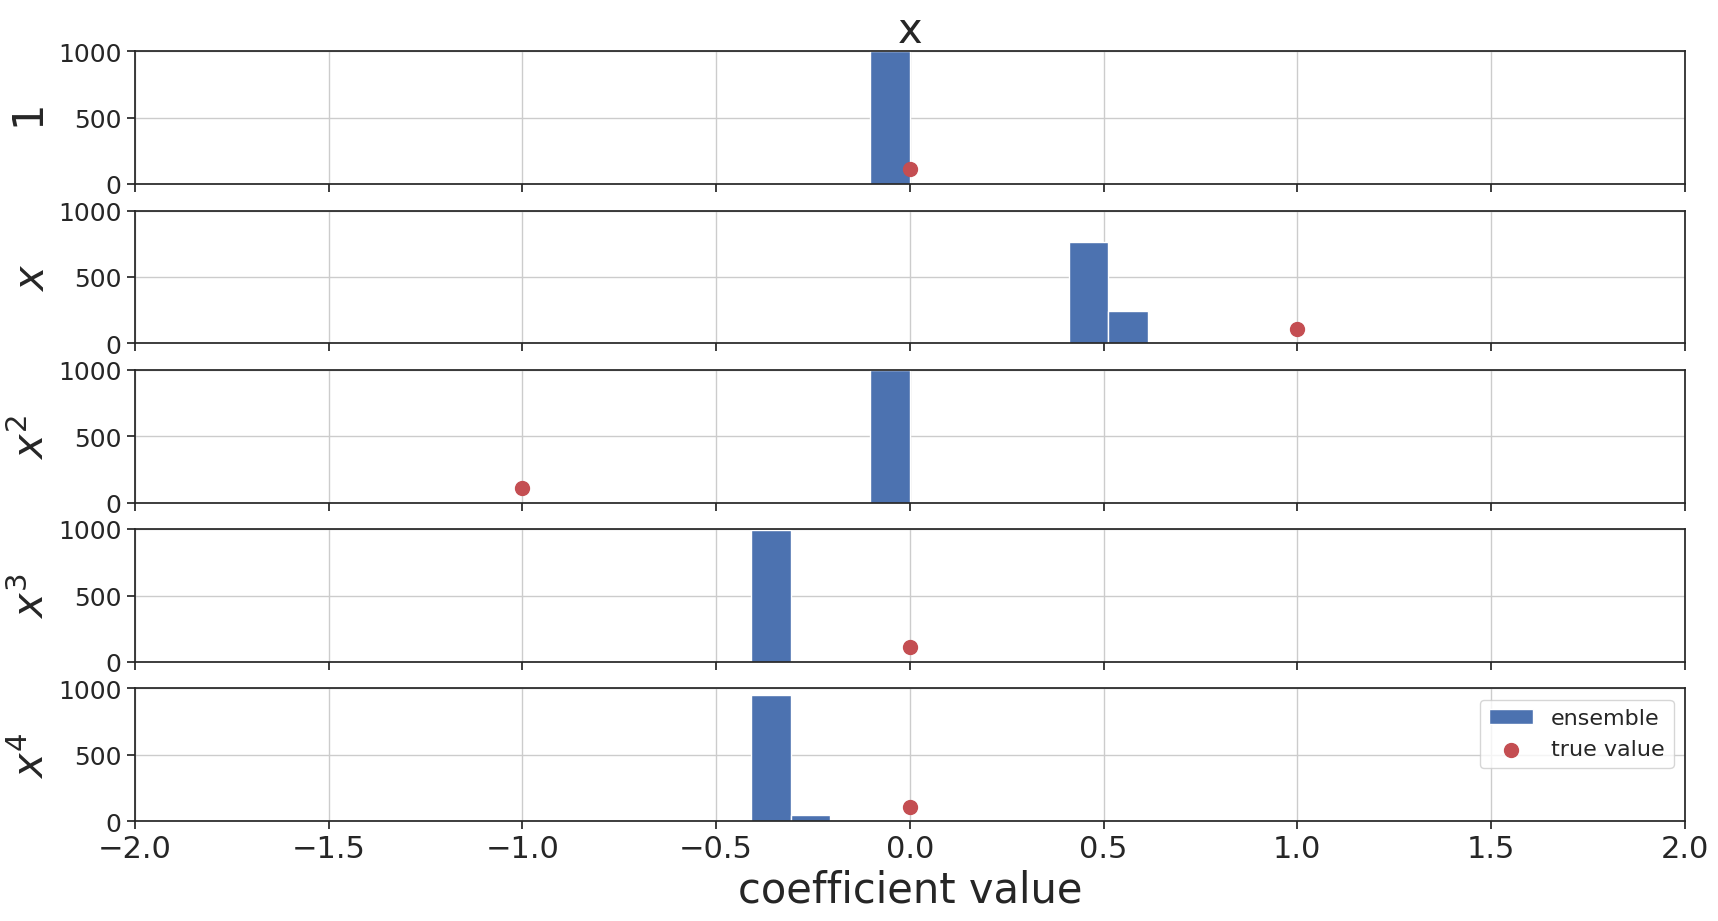

In [25]:
# Fit the WEAK ensemble SINDy
model, ensemble_coefs = fit_weak_ensemble_sindy(
    x_train, t_train, max_degree=4, n_models=1000
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Disastrous again! :(

That is, disastrous in terms of model selection—as we see in the following figure, the proposed model is not far from the true model in terms of its predictions, although the terms are completely wrong.

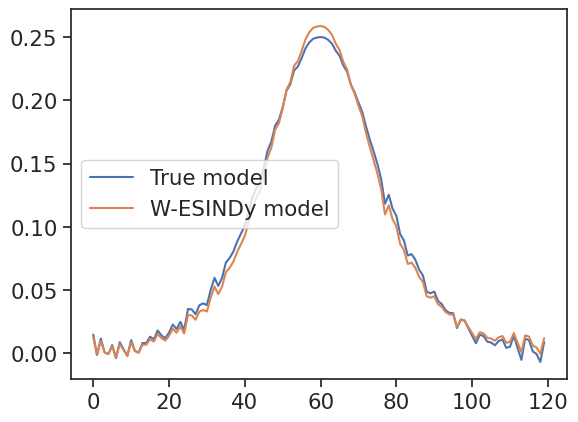

In [26]:
plt.plot(x_train - x_train**2, label='True model')
plt.plot(
    0.834 * x_train + -1.704 * x_train**3 + 0.875 * x_train**4,
    label = 'W-ESINDy model',
)
plt.legend()
plt.show()

#### Hyperparameter tuning for the larger library

In [27]:
for threshold in np.arange(.1, .90001, .1):
    print(f'Threshold = {threshold}', file=sys.stderr)
    model, ensemble_coefs = fit_weak_ensemble_sindy(
        x_train, t_train, max_degree=4, n_models=1000,
        threshold=threshold,
    )
    model.print()


Threshold = 0.1


(x)' = 0.831 x + -1.666 x^3 + 0.841 x^4


Threshold = 0.2


(x)' = 0.835 x + -1.690 x^3 + 0.861 x^4


Threshold = 0.30000000000000004


(x)' = 0.000


Threshold = 0.4


(x)' = 0.000


Threshold = 0.5


(x)' = 0.000


Threshold = 0.6


(x)' = 0.000


Threshold = 0.7000000000000001


(x)' = 0.000


Threshold = 0.8


(x)' = 0.000


Threshold = 0.9


(x)' = 0.000


It goes from overfitting to underfitting, without ever getting the true model.

## Systematic analysis of the logistic data

In [ ]:
# Get all files
fnames = [
    f for f in os.listdir('Data/logistic_noise_data/') if f.startswith ('0') and f.endswith('.pkl')
]
fnames.sort()

# Apply W-ESINDy to all files
results = []
for max_degree in range(2, 5):
    for fn in tqdm(fnames):
        # Prepare the data
        data, sigma, dt = read_logistic_data(fn)
        x_train = data.B.to_numpy().reshape((len(data.B), 1))
        t_train = data.t.to_numpy().reshape((len(data.B), 1))
    
        # Fit the model
        model, ensemble_coefs = fit_weak_ensemble_sindy(
            x_train, t_train, max_degree=max_degree, n_models=1000,
            threshold=.1,
        )
    
        # Is the model correct?
        nonzero_terms = get_nonzero_terms(model)
        if nonzero_terms == ['x', 'x^2']:
            results.append([max_degree, sigma, 1])
        else:
            results.append([max_degree, sigma, 0])

 68%|███████████████████████████▉             | 517/760 [08:16<03:57,  1.02it/s]

In [ ]:
df = pd.DataFrame(results, columns=['degree', '$\sigma$', 'rw'])
sns.lineplot(data=df, x='$\sigma$', y='rw', hue='degree', markers=True)
plt.plot()

## Lotka-Volterra

$$\dot{x} = 0.1 x - 0.02 xy$$
$$\dot{y} = -0.4 y + 0.02 xy$$

In [ ]:
# Read data
def read_lv_data(fname):
    data = pd.read_csv('Data/lotka_volterra_noise_data/' + fname, index_col=0)
    # Check if data are equispaced in time
    ts = data.t
    dt = ts[1] - ts[0]
    # Get the noise level from the file name!
    try:
        sigma = float(fname.split('_')[0])
    except:
        sigma = np.nan
    return data, sigma, dt

#### Very low noise

In [ ]:
data, sigma, dt = read_lv_data('0.1_0.csv')
x_train = data[['x', 'y']].to_numpy().reshape((len(data.x), 2))
t_train = data.t.to_numpy().reshape((len(data.x), 1))
plot_data(x_train)

In [ ]:
# Fit the WEAK ensemble SINDy
model, ensemble_coefs = fit_weak_ensemble_sindy(
    x_train, t_train, max_degree=3, n_models=1000,
    threshold=0.01,
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Pretty good! Recovers the correct model even with larger library!

**Note** that we had to change the threshold to 0.01 because model parameters are small overall!

#### Low noise 

In [ ]:
data, sigma, dt = read_lv_data('1.0_0.csv')
x_train = data[['x', 'y']].to_numpy().reshape((len(data.x), 2))
t_train = data.t.to_numpy().reshape((len(data.x), 1))
plot_data(x_train)

In [ ]:
# Fit the WEAK ensemble SINDy
model, ensemble_coefs = fit_weak_ensemble_sindy(
    x_train, t_train, max_degree=3, n_models=1000,
    threshold=0.01,
)
model.print()

# Median over coefficients over all samples
print(model.coefficients())
print(np.median(ensemble_coefs, axis=0))

# Extract non-zero terms from the ensemble
print(get_nonzero_terms(model))

# Plot distributions of coefficients
plot_lorenz_coef_dist(ensemble_coefs)

Already misbehaving :(

But, does it approximate the derivatives well?

In [ ]:
x, y = x_train[:, 0], x_train[:, 1]

# X
plt.plot(x, 0.1 * x - .02 * x * y, label='True model')
plt.plot(
    x, 
    0.102 + 0.092 * x + -0.018 * y + -0.019 * x * y,
    label = 'W-ESINDy model',
)
plt.ylabel('$\dot{x}$')
plt.legend()
plt.show()

# Y
plt.plot(y, -.4 * y + .02 * x * y, label='True model')
plt.plot(
    y, 
    0.006 + -0.410 * y + 0.020 * x * y,
    label = 'W-ESINDy model',
)
plt.ylabel('$\dot{y}$')
plt.legend()
plt.show()

#### Systematic analysis of the noisy Lotka-Volterra data

In [ ]:
# Get all files
fnames = [
    f for f in os.listdir('Data/lotka_volterra_noise_data/')
    if f.endswith('.csv') and not f.startswith('fit_')
]
fnames.sort()

# Apply W-ESINDy to all files
results = []
for max_degree in range(2, 4):
    for fn in tqdm(fnames):
        # Prepare the data
        data, sigma, dt = read_lv_data(fn)
        x_train = data[['x', 'y']].to_numpy().reshape((len(data.x), 2))
        t_train = data.t.to_numpy().reshape((len(data.x), 1))    
        # Fit the model
        model, ensemble_coefs = fit_weak_ensemble_sindy(
            x_train, t_train, max_degree=max_degree, n_models=1000,
            threshold=.01,
        )
    
        # Is the model correct?
        nonzero_terms = get_nonzero_terms(model)
        if nonzero_terms == ['x', 'xy', 'y', 'xy']:
            results.append([max_degree, sigma, 1])
        else:
            results.append([max_degree, sigma, 0])

In [ ]:
df = pd.DataFrame(results, columns=['degree', '$\sigma$', 'rw'])
sns.lineplot(data=df, x='$\sigma$', y='rw', hue='degree', markers=True)
plt.xscale('log')
plt.plot()